## Colab vorbereiten

In [ ]:
###########################################
# Init SSH to VS Code
###########################################
# tutorial from https://pypi.org/project/colab-ssh/
###########################################

# Install colab_ssh on google colab
!pip install colab_ssh --upgrade

# imports
from colab_ssh import launch_ssh, init_git

# fill in token from https://dashboard.ngrok.com/auth/your-authtoken
token = '1dV1bjDpRPVLn3uH3boT0GaQrfV_B644Wsk8PfN9iUefDtc8'

# set up a password
password = 'DL2020'
launch_ssh(token, password)

# Optional: if you want to clone a github repository
init_git("https://github.com/JuAbels/joint-vae")

Successfully running 2.tcp.ngrok.io:19786
[Optional] You can also connect with VSCode SSH Remote extension using this configuration:

	Host google_colab_ssh
		HostName 2.tcp.ngrok.io
		User root
		Port 19786
	  
Successfully cloned the repository


In [ ]:
from google.colab import drive
drive.mount('/content/grive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/grive


## Sachen ausprobieren

In [ ]:
# Loading the model
from utils.load_model import load
path_to_model_folder = '/content/joint-vae/trained_models/mnist/'
model = load(path_to_model_folder)
print(model.latent_spec)

{'disc': [10], 'cont': 10}


In [ ]:
from torch import Tensor
latent = Tensor([0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,
                 0,1,0,0,0,0,0,0,0,0])
from viz.visualize import Visualizer
v = Visualizer(model)
img_sample = v._decode_latents(latent)
from torchvision.utils import save_image
save_image(img_sample,'test2.png')

## Definition des Dataloaders

In [ ]:
import glob
import numpy as np
from skimage.io import imread
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
import pandas as pd
import os
import numpy as np

class LettersDataset(Dataset):
    """Letters dataset with 64 by 64 images."""
    def __init__(self, path_to_data, subsample=1, transform=None):
        """
        Parameters
        ----------
        subsample : int
            Only load every |subsample| number of images.
        """
        #self.img_paths = glob.glob(path_to_data + '/*')[::subsample]
        self.transform = transform
        self.images = pd.read_csv(os.path.join(path_to_data,"LatinLetters.csv"))
        self.images = self.images.drop(labels="0",axis='columns')

    def __len__(self):
        return len(self.images.index)

    def __getitem__(self, idx):
        sample = self.images.iloc[[idx]]
        sample = np.uint8(sample.to_numpy().reshape((28,28)))
        #sample = imread(sample_path)

        if self.transform:
            sample = self.transform(sample)
        # Since there are no labels, we just return 0 for the "label" here
        return sample, 0

def get_letters_dataloader(batch_size=128, path_to_data='grive/My Drive/'):
    """Letters dataloader with (32, 32) images."""
    all_transforms = transforms.Compose([
        transforms.ToTensor(),
        transforms.ToPILImage(),
        transforms.Resize(32),
        transforms.ToTensor()
    ])
    letters_data = LettersDataset(path_to_data,
                                transform=all_transforms)
    letters_loader = DataLoader(letters_data, batch_size=batch_size,
                               shuffle=True)
    return letters_loader

## Modelldefinition

In [ ]:
data_loader = get_letters_dataloader(batch_size=64, path_to_data='grive/My Drive/')

In [ ]:
# Latent distribution will be joint distribution of 10 gaussian normal distributions
# and one 10 dimensional Gumbel Softmax distribution
latent_spec = {'cont': 5,
               'disc': [13]}

In [ ]:
from jointvae.models import VAE

model = VAE(latent_spec=latent_spec, img_size=(1, 32, 32),use_cuda=True)

In [ ]:
from torch import optim

# Build optimizer
optimizer = optim.Adam(model.parameters(), lr=5e-4)

In [ ]:
from jointvae.training import Trainer

# Define the capacities
# Continuous channels
cont_capacity = [0.0, 5.0, 25000, 30.0]  # Starting at a capacity of 0.0, increase this to 5.0
                                         # over 25000 iterations with a gamma of 30.0
# Discrete channels
disc_capacity = [0.0, 5.0, 25000, 30.0]  # Starting at a capacity of 0.0, increase this to 5.0
                                         # over 25000 iterations with a gamma of 30.0

# Build a trainer
trainer = Trainer(model, optimizer,
                  cont_capacity=cont_capacity,
                  disc_capacity=disc_capacity,
                  use_cuda=True)

In [ ]:
# Build a visualizer which will be passed to trainer to visualize progress during training
from viz.visualize import Visualizer

viz = Visualizer(model)

## Training

In [ ]:
# Train model for 10 epochs
# Note this should really be a 100 epochs and trained on a GPU, but this is just to demo
from torch import save

epochs = 50
trainer.train(data_loader, epochs=epochs, save_training_gif=('./training.gif', viz))
save(trainer.model.state_dict(), 'letter_model.pt')

0/372450	Loss: 767.015
3200/372450	Loss: 581.141
6400/372450	Loss: 338.495
9600/372450	Loss: 305.577
12800/372450	Loss: 302.209
16000/372450	Loss: 302.104
19200/372450	Loss: 302.373
22400/372450	Loss: 301.921
25600/372450	Loss: 300.674
28800/372450	Loss: 300.284
32000/372450	Loss: 299.076
35200/372450	Loss: 297.622
38400/372450	Loss: 296.175
41600/372450	Loss: 295.991
44800/372450	Loss: 293.012
48000/372450	Loss: 293.468
51200/372450	Loss: 291.415
54400/372450	Loss: 292.748
57600/372450	Loss: 291.499
60800/372450	Loss: 289.877
64000/372450	Loss: 288.402
67200/372450	Loss: 290.289
70400/372450	Loss: 288.296
73600/372450	Loss: 286.088
76800/372450	Loss: 286.300
80000/372450	Loss: 285.294
83200/372450	Loss: 284.693
86400/372450	Loss: 285.867
89600/372450	Loss: 284.553
92800/372450	Loss: 281.808
96000/372450	Loss: 282.609
99200/372450	Loss: 281.208
102400/372450	Loss: 282.557
105600/372450	Loss: 279.865
108800/372450	Loss: 279.867
112000/372450	Loss: 279.297
115200/372450	Loss: 278.561
118

## Ergebnis Visualization

Verlauf Loss-Funktion

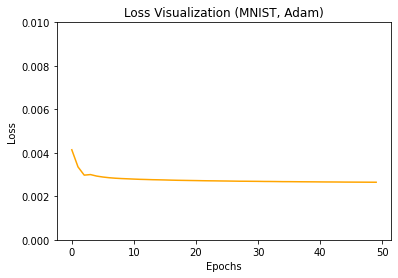

In [ ]:
import sys
# insert at 1, 0 is the script path (or '' in REPL)
sys.path.insert(1, 'grive/My Drive')

# Own coded function imports
from chart_view import chart_viewer

# Show Chart of Loss
# x-Achse: Epochenanzahl
xdata = np.arange(epochs)
# y-Achse: loss des trainers (in training.py)
ydata = trainer.loss_arr
# chart_viewer(title, xlabel, ylabel, data for x-achse, data for y-achse)
# wird gespeichert unter title
chart_viewer("Loss Visualization (MNIST, Adam)", "Epochs", "Loss", xdata, ydata)

In [ ]:
viz.save_images = True
viz.all_latent_traversals(13)
viz.samples()
viz.latent_traversal_grid(cont_idx=0, cont_axis=1, disc_idx=0, disc_axis=0, 
                          size=(26, 10), filename='traversal_grid1.png')
viz.latent_traversal_grid(cont_idx=1, cont_axis=1, disc_idx=0, disc_axis=0, 
                          size=(26, 10), filename='traversal_grid2.png')
viz.latent_traversal_grid(cont_idx=2, cont_axis=1, disc_idx=0, disc_axis=0, 
                          size=(26, 10), filename='traversal_grid3.png')
viz.latent_traversal_grid(cont_idx=3, cont_axis=1, disc_idx=0, disc_axis=0, 
                          size=(26, 10), filename='traversal_grid4.png')
viz.latent_traversal_grid(cont_idx=4, cont_axis=1, disc_idx=0, disc_axis=0, 
                          size=(26, 10), filename='traversal_grid5.png')
#viz.latent_traversal_grid(cont_idx=5, cont_axis=1, disc_idx=0, disc_axis=0, 
#                          size=(26, 10), filename='traversal_grid6.png')
#viz.latent_traversal_grid(cont_idx=6, cont_axis=1, disc_idx=0, disc_axis=0, 
#                          size=(26, 10), filename='traversal_grid7.png')
#viz.latent_traversal_grid(cont_idx=7, cont_axis=1, disc_idx=0, disc_axis=0, 
#                          size=(26, 10), filename='traversal_grid8.png')

In [ ]:
#import sys
#insert at 1, 0 is the script path (or '' in REPL)
#sys.path.insert(1, 'joint-vae/viz')
#from importlib import reload
#reload(visualize)
#import visualize
#v = visualize.Visualizer(model)
#dataloader = get_letters_dataloader(batch_size=64, path_to_data='grive/My Drive/')
for batch, labels in data_loader:
    break

viz.reconstructions(batch, size=(8, 8), filename='recon.png')

./joint-vae/viz/visualize.py:41: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  input_data = Variable(data, volatile=True)


In [ ]:
del sys.modules["visualize"]
import sys
sys.modules.keys()

dict_keys(['builtins', 'sys', '_frozen_importlib', '_imp', '_warnings', '_thread', '_weakref', '_frozen_importlib_external', '_io', 'marshal', 'posix', 'zipimport', 'encodings', 'codecs', '_codecs', 'encodings.aliases', 'encodings.utf_8', '_signal', '__main__', 'encodings.latin_1', 'io', 'abc', '_weakrefset', '_bootlocale', '_locale', 'warnings', 're', 'enum', 'types', 'functools', '_functools', 'collections', '_collections_abc', 'operator', '_operator', 'keyword', 'heapq', '_heapq', 'itertools', 'reprlib', '_collections', 'weakref', 'collections.abc', 'sre_compile', '_sre', 'sre_parse', 'sre_constants', 'copyreg', 'site', 'os', 'errno', 'stat', '_stat', 'posixpath', 'genericpath', 'os.path', '_sitebuiltins', 'sysconfig', '_sysconfigdata_m_linux_x86_64-linux-gnu', 'importlib', 'importlib._bootstrap', 'importlib._bootstrap_external', 'importlib.util', 'importlib.abc', 'importlib.machinery', 'contextlib', 'google', 'google.cloud', 'google.logging', 'mpl_toolkits', 'sphinxcontrib', 'sitec

Go to the google Colab console (ctrl+shift+i) :

function ClickConnect(){
console.log("Working"); 
document.querySelector("colab-connect-button").click() 
}setInterval(ClickConnect,60000)